In [265]:
import torch

import numpy as np
import matplotlib.pyplot as plt

import os
import sys
sys.path.append(os.path.join(os.path.abspath(''), '..'))
from scripts.utils import auto_corr
from scripts.gan import Generator

In [266]:
X = np.load('../data/X.npy')
X = torch.tensor(X, dtype=torch.float32)
y = np.load('../data/y.npy')
y = torch.tensor(y, dtype=torch.float32)
X = X[y == 0]
X_min = X.min()
X_max = X.max()
print(X_min, X_max)
X = X.reshape(-1, 1, 1, 96)
X.shape

tensor(-0.3649) tensor(7883.3579)


torch.Size([2069, 1, 1, 96])

In [267]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

G = Generator()
G.load_state_dict(torch.load('../models/best_generator_regime0.pth'))
G.to(device);

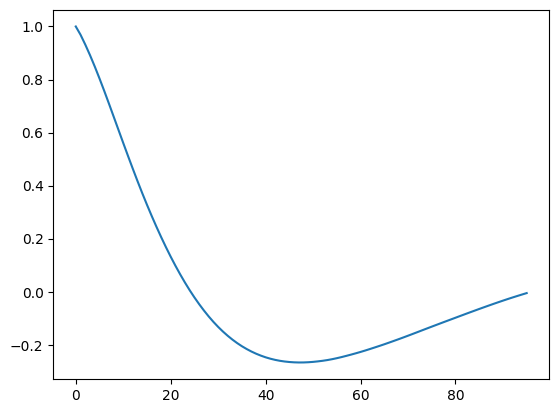

In [274]:
plt.plot([auto_corr(X, i).mean() for i in range(96)])

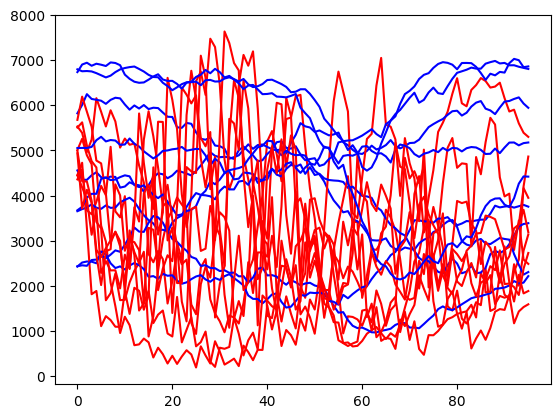

In [270]:
G.eval()
fake_data = G(torch.randn(1, 100, 1, 1, device=device))[:,:,:,25:-25].reshape(-1, 96).cpu()
fake_data = fake_data * (X_max - X_min) + X_min
for i in range(9):
    plt.plot(fake_data[i].detach().numpy(), color='red')
    plt.plot(X[i, 0, 0].detach().numpy(), color='blue')
plt.show()